### Decision Tree (DecisionTree.ipynb)

Train a Decision Tree using a ChoiceMaker to decide when to stop branching.

Goal: See how a ChoiceMaker performs when applied to a novel area. Having the lowest error 
compared to naive methods would be great.

Comparison: We compare against a naive way of making a decision tree algorithm
private, as well as another method described in a sketchy paper. I implemented
everything.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Improvement 1: figure out a way to make epsilon equal to 1.0 always.
Improvement 2: simplify the error computations.


In [2]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle
import collections
import numpy as np
import pandas as pd
from decision_tree import CoefCM, Leaf, Split, DB, DBMetas, PDTree

In [3]:
#Retrain flags!
rerun_gen_training_data = False
rerun_train_cms = False
rerun_exps = [False, False, True, True, True]

In [4]:
tree_algs = {'leaf': Leaf(), 'split': Split()}
"""

This competitor algorithm appears in:

Sam Fletcher and Md Zahidul Islam. Decision Tree Classification with Differential Privacy: A Survey.
In CoRR, volume = abs/1611.01919, 2016

This algorithm was chosen because it is "subsumed" by Jostle, meaning its code can be represented internally
by Jostle's trees.
"""
fried_cm = CoefCM([1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [5]:
adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.core' is private. Use 'pandas.Categorical'
  """Entry point for launching an IPython kernel.


In [6]:
class null_cm:
    def __init__(self):
        self.leaf = Leaf()
        self.split = Split()
    def choose(self, db):
        if db.depth < db.max_depth:
            return self.split.run(db)
        else:
            return self.leaf.run(db)

### Experiments

In [7]:
"""
Performs dataset surgery on a seed_db. Parameters such as target number of rows are fixed here, 
which makes sense because seed databases are roughly the same size in this experiment.

Parameters:
seed_db: dataset to slice up
eps: value of epsilon for the experiments
prng: random number generator
returns a tuple: (regret of algorithm on each db, metafeatures associated with db, and the db itself)
"""
def get_train_dbs(seed_db, eps, prng):
    regs = []
    X = []
    D = []
    for l in range(1, 4): #Used to be 6
        for x in range(2**(l+3)):
            cols = prng.permutation(seed_db.columns[:-1])
            db_groups = seed_db.groupby(list(cols[:l])).groups
            idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
            L = idxs.size
            L = min(L, 5000)
            L = prng.randint(0.7*L, L)
            idxs = prng.choice(idxs, L)
            data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
            regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
            X.append(DBMetas()(data))
            D.append(data)
    #Large DBs    
    for x in range(16):
        cols = seed_db.columns[:-1]
        L = len(seed_db)
        L = min(L, 5000)
        L = prng.randint(0.7*L, L)
        new_db = seed_db.sample(L, random_state=prng)
        data = DB(new_db.loc[:, cols], new_db.loc[:, seed_db.columns[-1]], None, None, epsilon=eps, depth=0)
        regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
        X.append(DBMetas()(data))
        D.append(data)
    return (regs, X, D)

In [8]:
"""
Does a similar thing as get_train_dbs, but makes fewer slices, and the slices are large
because these are databases we want to test on (and we probably won't be using tiny dbs in real life).
"""

def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [9]:
directory = '/longterm/jimola/data_train.pkl'
if rerun_gen_training_data:
    prng=np.random.RandomState(12345)
    eps_vals = np.array([0.05, 0.1, 0.25, 0.5, 0.8])
    def get_test(db, prng):
        dbs = []
        for i in range(0, 3):
            for e in eps_vals:
                dbs.append(get_train_dbs(db, e, prng))
        return dbs
    data_train = [get_test(db, prng) for db in \
                  [nurs, default, loan, adult, lending]]
    pickle.dump(data_train, open(directory, 'wb'))
else:
    #These dbs take up a ton of memory. They are not on the github repo but they are in a directory on Matt's machine
    data_train = pickle.load(open(directory, 'rb'))

In [10]:
"""
Trains a choicemaker

Parameters:
info: list of (regrets, metafeatures, db) tuples. 
            db is actually not needed; could just be a metafeature list.
"""
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

if rerun_train_cms:
    cms = [get_cm(o) for o in data_train]
    mfs = [cm.X for cm in cms]
    regs = [cm.regrets for cm in cms]
    pickle.dump(mfs, open('decision_tree_metadata/data.pkl', 'wb'))
    pickle.dump(regs, open('decision_tree_metadata/regrets.pkl', 'wb'))
else:
    mfs = pickle.load(open('decision_tree_metadata/data.pkl', 'rb'))
    regs = pickle.load(open('decision_tree_metadata/regrets.pkl', 'rb'))
    cms = [ DTChoice(mfs[i], DBMetas(), tree_algs, regrets=regs[i]) for i in range(len(mfs))]

In [11]:
"""
A convenience method for taking training data in choicemakers and combining it into one choicemaker.
Used in my experiments for leave-one-out cross validation.

Parameters:
cms: list of choicemakers.
C, msl: parameters of the choicemaker's internal tree, but not super important as they can be set later.
"""
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [12]:
"""
Tests a set of choicemakers on a test of databases and returns % classified correctly.
Parameters:
cm_list: list of choicemakers.
dbs: list of test dbs.
"""
def get_results(dbs, cm_list):
    budgets = [x.epsilon for x in dbs]
    ans = []
    for cm in cm_list:
        dt = PDTree()
        L = []
        for t in dbs:
            L.append( dt.fit_and_predict(t, cm) )
            #print(dt.leaf.numruns)
        for i in range(len(dbs)):
            dbs[i].epsilon = budgets[i]
        M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
        ans.append(M)
    return ans

In [13]:
#Reinitialize prng before the experiments so we can reproduce their exact runs
prng = np.random.RandomState(12345)

### Experiment 0

In [14]:
"""
Format for the experiments:
outsample_cm{i} is the choicemaker for all databases from which the test database are not generated, 
        a sort of leave-one-out cross-validation.
insample_cm{i} is the complement of big_cm{i}, so the same database is used for both training and
        testing data. This is to serve as a comparison.
I set the depth of the internal tree to 4,
    and min. samples per leaf (see sklearn documentation) to 10, somewhat arbitrarily.
I test using epsilon=0.25 and run 5 trials for each experiment on each database. This could certainly be increased
as the error bars have high noise.
"""
epsilon = 0.25
num_trials = 5

In [15]:
def run_experiment(i, db, msl=10, md=4):
    insample_cm = cms[i]
    insample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    insample_cm.retrain_model()
    outsample_cm = combine_cms(cms[:i] + cms[(i+1):])
    outsample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    outsample_cm.retrain_model()
    if rerun_exps[i]:
        res = get_results(db, [null_cm(), outsample_cm, insample_cm, fried_cm])
        pickle.dump(res0, open('decision_tree_results/experiment%d.pkl' % i, 'wb'))
    else:
        res = pickle.load(open('decision_tree_results/experiment%d.pkl' % i, 'rb'))
    return res

In [16]:
nursdata = [get_test_dbs(nurs, epsilon, prng) for x in range(0, num_trials)]
res0 = run_experiment(0, nursdata)

In [17]:
np.array(res0).mean(axis=1)

array([0.38088367, 0.53083703, 0.55432364, 0.5441282 ])

### Experiment 1

In [18]:
defaultsdata = [get_test_dbs(default, epsilon, prng) for i in range(0, num_trials)]
res1 = run_experiment(1, defaultsdata)

In [19]:
(np.array(res1)).mean(axis=1)

array([0.68098526, 0.7832593 , 0.77740296, 0.76155978])

### Experiment 2

In [20]:
loandata = [get_test_dbs(loan, epsilon, prng) for i in range(num_trials)]
res2 = run_experiment(2, loandata)

In [21]:
np.array(res2).mean(axis=1)

array([0.57311085, 0.89991541, 0.89991541, 0.89991541])

### Experiment 3

In [22]:
adultdata = [get_test_dbs(adult, epsilon, prng) for i in range(num_trials)]
res3 = run_experiment(3, adultdata)

In [23]:
np.array(res3).mean(axis=1)

array([0.67459951, 0.76163534, 0.76163534, 0.76344575])

### Experiment 4

In [24]:
lendingdata = [get_test_dbs(lending, epsilon, prng) for x in range(num_trials)]
res4 = run_experiment(4, lendingdata)

In [25]:
np.array(res4).mean(axis=1)

array([0.62547642, 0.85044425, 0.8342078 , 0.83395231])

In [26]:
E = np.array([res0,res1,res2,res3,res4])

In [27]:
#E[dataset][algorithm][trial]
stds = E.std(axis=2).mean(axis=0)

In [28]:
errors = 1.0-E.mean(axis=2).mean(axis=0)

In [29]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [30]:
colors = ['red', 'blue', 'green', 'orange']

In [31]:
patches = [mpatches.Patch(color=c) for c in colors]

<BarContainer object of 4 artists>

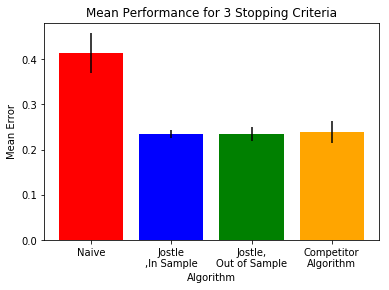

In [32]:
fig, axis = plt.subplots()
axis.set_xticks([0,1,2,3])
axis.set_xticklabels(['Naive','Jostle\n,In Sample','Jostle,\nOut of Sample','Competitor\nAlgorithm'])
axis.set_xlabel('Algorithm')
axis.set_ylabel('Mean Error')
#axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Performance for 3 Stopping Criteria')
axis.bar(range(4), errors, color=colors, yerr=stds)